# 1. Imports

In [2]:
import numpy as np
from urllib import request
import gzip
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 2. Data Loading and Exploration 

In [4]:
def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/" # "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [7]:
init()
# # Load and normalize synthetic data
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()

print("Training data shape:", xtrain.shape)
print("Training labels shape:", ytrain.shape)
print("Validation data shape:", xval.shape)
print("Validation labels shape:", yval.shape)


Download complete.
Save complete.
Training data shape: (55000, 784)
Training labels shape: (55000,)
Validation data shape: (5000, 784)
Validation labels shape: (5000,)


In [8]:
xtrain

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

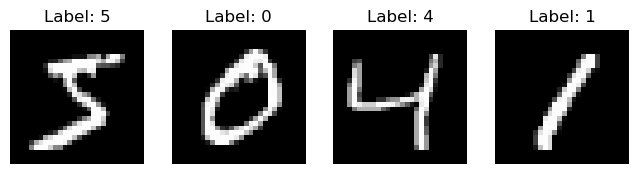

In [11]:
import matplotlib.pyplot as plt

# Plot a grid of sample images
num_samples = 4  
plt.figure(figsize=(8, 8))
for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(xtrain[i].reshape(28, 28), cmap='gray')  
    plt.title(f"Label: {ytrain[i]}")
    plt.axis('off')
plt.show()


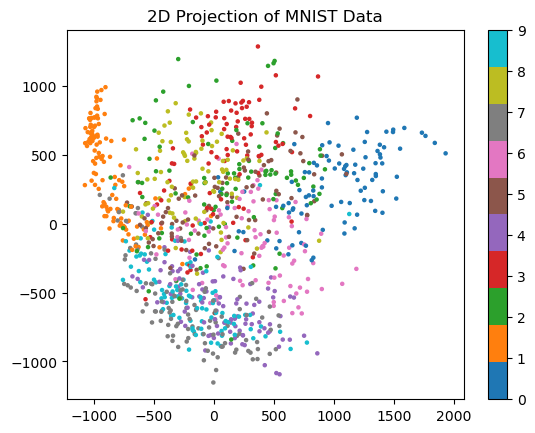

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Use PCA or t-SNE for dimensionality reduction
reduced_data = PCA(n_components=2).fit_transform(xtrain[:1000])  
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=ytrain[:1000], cmap='tab10', s=5)
plt.colorbar()
plt.title("2D Projection of MNIST Data")
plt.savefig('pca')
plt.show()


In [15]:
print("Max pixel value:", xtrain.max())
print("Min pixel value:", xtrain.min())


Max pixel value: 255
Min pixel value: 0


In [17]:
print("Mean pixel value:", xtrain.mean())
print("Standard deviation of pixel values:", xtrain.std())


Mean pixel value: 33.332771405380335
Standard deviation of pixel values: 78.5901436214457


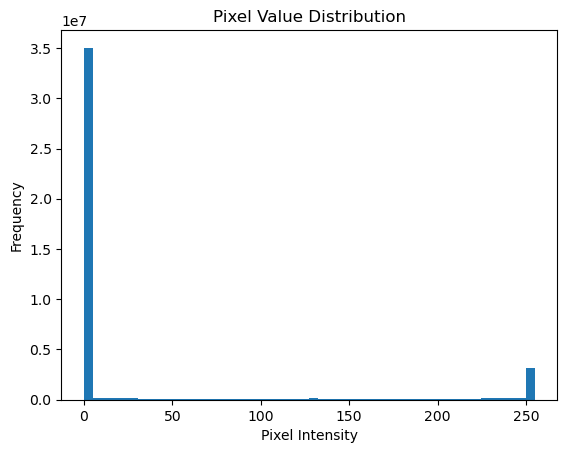

In [19]:
plt.hist(xtrain.flatten(), bins=50)
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()